# Weighted histograms with the Apache Spark DataFrame API 

This provides and example of how to generate weighted histograms using the Spark DataFrame API.  
A weighted histogram is a generalization of a frequency histogram. It takes into account weights for each value entry. When all weights are set to 1, the weighted histogram is a frequency/count histogram.  
Disambiguation: we refer here to computing histograms of the DataFrame data, rather than histograms of the columns statistics used by the cost based optimizer.   

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# the use of findspark is optional

# install pyspark if needed
# ! pip install pyspark

# import findspark
# findspark.init("/home/luca/Spark/spark-3.3.0-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("PySpark histograms")
         .master("local[*]")
         .getOrCreate()
        )

## Generate a DataFrame with toy data for demo purposes

In [2]:
num_events = 100
scale = 100
seed1 = 4242
seed2 = 4243

df = spark.sql(f"""
select random({seed1}) * {scale} as random_value,
       random({seed2}) as weight 
from range({num_events})
""")

df.show(5)

+------------------+-------------------+
|      random_value|             weight|
+------------------+-------------------+
|1.4207335464797133|0.24909057521664535|
|   28.332185796207| 0.3578315443426291|
|35.723647283875394| 0.3591395211139339|
| 31.40224866468887| 0.6105959208250227|
|60.990188101279166|0.10255912075785512|
+------------------+-------------------+
only showing top 5 rows



## Compute the weighted histogram

In [ ]:
# import the computeWeightedHistogram function 
# see implementation details at: 
# https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_Histograms/python/sparkhistogram/histogram.py

# requires the package sparkhistogram
! pip install sparkhistogram

from sparkhistogram import computeWeightedHistogram


In [4]:
# Compute the histogram using the computeWeightedHistogram function

histogram = computeWeightedHistogram(df, "random_value", "weight", -20, 90, 11)

# Alternative syntax: compute the histogram using transform on the DataFrame
# requires Spark 3.3.0 or higher
# histogram = df.transform(computeWeightedHistogram, "random_value", "weight", -20, 90, 11)

# this triggers the computation as show() is an action
histogram.show()

+------+-----+------------------+
|bucket|value|      weighted_sum|
+------+-----+------------------+
|     1|-15.0|               0.0|
|     2| -5.0|               0.0|
|     3|  5.0|2.3311284945146147|
|     4| 15.0| 4.076542801479973|
|     5| 25.0|  8.18499877878322|
|     6| 35.0| 5.270321110145988|
|     7| 45.0| 5.581395504223541|
|     8| 55.0|3.4259555156362604|
|     9| 65.0| 3.160802943654561|
|    10| 75.0| 7.896726387145422|
|    11| 85.0| 4.783329763967291|
+------+-----+------------------+



In [5]:
# Fetch the histogram data into a Pandas DataFrame for visualization
# At this stage data is reduced to a small number of rows (one row per bin)
# so it can be easily handled by one machine

# toPandas() is an action and triggers the computation
hist_pandasDF = histogram.toPandas()

hist_pandasDF

,bucket,value,weighted_sum
0,1,-15.0,0.000000
1,2,-5.0,0.000000
2,3,5.0,2.331128
3,4,15.0,4.076543
4,5,25.0,8.184999
5,6,35.0,5.270321
6,7,45.0,5.581396
7,8,55.0,3.425956
8,9,65.0,3.160803
9,10,75.0,7.896726


## Histogram plotting
This plots the weighted histogram: wheighted sum of the number of per bin.

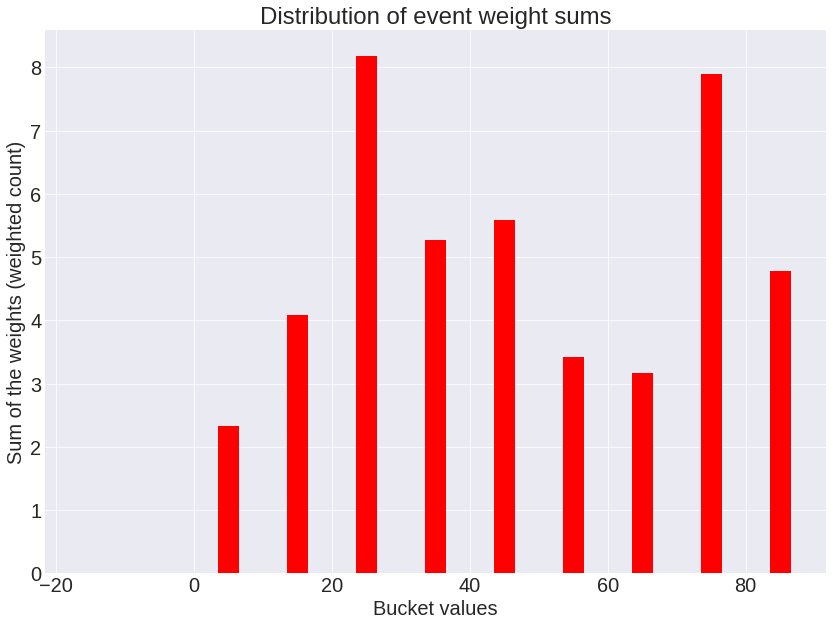

In [6]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["weighted_sum"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel('Bucket values')
ax.set_ylabel('Sum of the weights (weighted count)')
ax.set_title("Distribution of event weight sums")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

In [7]:
spark.stop()

##  Note added
Use this to define the computeWeightedHistogram function if you cannot pip install sparkhistogram

In [ ]:
from pyspark.sql.functions import sum

def computeWeightedHistogram(df: "DataFrame", value_col: str, weight_col: str,
                             min: int, max: int, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the weighted histogram of a DataFrame column.
        A weighted histogram is a generalization of a frequency histogram.
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
                   the column needs to be of numeric type
        weight_col: numeric-type column with the weights, 
                    the bucket value is computed as sum of weights.
                    If all weight are set to 1, you get a frequency histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: weighted sum of the number of values in the bucket        
    """
    step = (max - min) / bins
    # this will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.sql(f"select id+1 as bucket from range({bins})")
    
    histdf = (df
              .selectExpr(f"width_bucket({value_col}, {min}, {max}, {bins}) as bucket", "weight")
              .groupBy("bucket")
              .agg(sum(f"{weight_col}").alias("weighted_sum"))  # sum the weights on the weight_col
              .join(df_buckets, "bucket", "right_outer") # add missing buckets and remove buckets out of range
              .selectExpr("bucket", f"{min} + (bucket - 1/2) * {step} as value", # use center value of the buckets
                          "nvl(weighted_sum, 0) as weighted_sum") # buckets with no values will have a sum of 0
              .orderBy("bucket")
             )
    return histdf
